In [219]:
# 외부 py 파일 수정 시 자동으로 재로드되도록 설정
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [224]:
# ================================================
# 📦 공통 패키지 import
# ================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
import sys

# src 경로 추가
PROJECT_ROOT = os.path.abspath(os.path.join(".."))
SRC_DIR = os.path.join(PROJECT_ROOT, "src")
if SRC_DIR not in sys.path:
    sys.path.append(SRC_DIR)

# seaborn 스타일 설정
sns.set(style="whitegrid")

# ================================================
# ⚙️ 경로 및 상수 설정
# ================================================
DATA_DIR = "../data/processed"
OUTPUT_DIR = "../data/modeling"
SEOUL_STATION_PATH = os.path.join(DATA_DIR, "seoul_env_station_mapped.csv")
OUTPUT_IMG = "../outputs/image"

os.makedirs(OUTPUT_DIR, exist_ok=True)

# KMeans 설정
KMEANS_MODE = "auto" # auto, manual
KMEANS_MANUAL_K = 5

# XGBoost 설정
XGB_N_ESTIMATORS = 100

# MCLP 설정
COVERAGE_RADIUS = 0.005
FACILITY_LIMIT = 30

# ================================================
# 🧪 평가 함수 import
# ================================================
from evaluation.baseline_evaluator import (
    evaluate_existing_stations,
    evaluate_random_installation,
    evaluate_cluster_centers,
    evaluate_mclp_result
)

# K-means

In [225]:
from modeling.kmeans_model import run_kmeans

# 데이터 로드
grid = pd.read_csv(f"{DATA_DIR}/grid_system_processed.csv")

# 수요가 가장 높은 클러스터만 추출
grid , used_k = run_kmeans(
    grid,
    mode=KMEANS_MODE,
    # manual_k=KMEANS_MANUAL_K,
    return_top_cluster_only=True
)

Finding optimal k: 100%|██████████| 9/9 [00:00<00:00, 42.12it/s]

[AUTO MODE] 최적 k = 2
Inertia by k: {2: 394878040.6060905, 3: 182752136.79175264, 4: 111630868.37625773, 5: 83130803.13068569, 6: 65292788.3815513, 7: 54917904.7908943, 8: 48181642.39693806, 9: 36633734.731904596, 10: 32347245.131689377}

[Cluster별 평균 수요]
cluster
1.0    1360.575095
0.0      57.366915
Name: demand_score, dtype: float64

[필터링] 수요가 가장 높은 클러스터 (cluster=1.0)만 반환됨.


KMeans로 수요 밀집 지역을 선별한 후,

해당 지역의 feature만 따로 정리해 저장하는 전처리 단계

→ 이후 모델(XGBoost, MCLP)에서 이 subset만 사용할 수 있게 함.

In [226]:
# 필요한 컬럼만 유지 (grid: KMeans 결과)
grid = grid[['grid_id', 'center_lat', 'center_lon', 'cluster']]

# 원본 feature 로드
features_all = pd.read_csv(f"{DATA_DIR}/grid_features.csv")

# 병합 전: features_all 좌표 제거 (혼동 방지)
features_all = features_all.drop(columns=['center_lat', 'center_lon'], errors='ignore')

# 병합
features = features_all.merge(grid, on='grid_id', how='inner')

# cluster 정수형 처리
features['cluster'] = features['cluster'].astype(int)

# 저장 전 좌표 정리: 이미 이름이 정돈돼 있음
# → center_lat, center_lon 이 grid 기준으로만 존재
features = features.loc[:, ~features.columns.duplicated()]  # 혹시 모를 중복 제거

# 저장
features.to_csv(f"{OUTPUT_DIR}/kmeans_grid_features.csv", index=False)
print("✅ 좌표 컬럼 중복 없이 정리 및 저장 완료")

# 확인
print(f"전체 feature 수: {len(features_all)}")
print(f"수요 밀집 클러스터 feature 수: {len(features)}")
print(f"병합 후 유지된 비율: {len(features) / len(features_all) * 100:.2f}%")
print(f"사용 가능한 feature 컬럼: {features.columns.tolist()}")

✅ 좌표 컬럼 중복 없이 정리 및 저장 완료
전체 feature 수: 6030
수요 밀집 클러스터 feature 수: 526
병합 후 유지된 비율: 8.72%
사용 가능한 feature 컬럼: ['grid_id', 'demand_score', 'supply_score', 'commercial_count', 'station_count', 'supply_demand_ratio', 'population_density', 'accessibility_score', 'transport_score', 'center_lat', 'center_lon', 'cluster']


In [ ]:
# 선택시항

from utils.inspect_dataframe import inspect_dataframe
from visualization.map_visualizer import visualize_cluster_map

# 1. kmeans_grid_features.csv 특징
inspect_dataframe(features, name="features")

# 2. kmeans 시각화 - 서울 전체 (회색) - 수요 (빨간색)
visualize_cluster_map(
    all_features_path=f"{DATA_DIR}/grid_features.csv",
    filtered_features_path=f"{OUTPUT_DIR}/kmeans_grid_features.csv",
    output_path=f"../outputs/maps/kmeans_visualization.html"
)

🧾 입력 데이터 이름: features
🔢 shape: (526, 13)
🔑 컬럼 목록:
['grid_id', 'demand_score', 'supply_score', 'commercial_count', 'station_count', 'supply_demand_ratio', 'population_density', 'accessibility_score', 'transport_score', 'center_lat', 'center_lon', 'cluster', 'predicted_demand_score']

🧾 예시 5개:
        grid_id  demand_score  supply_score  commercial_count  station_count  \
0  GRID_011_036        1372.5      27.15053               200              1   
1  GRID_011_037         911.5      27.15053               200              0   
2  GRID_012_035         883.0      27.15053               200              1   
3  GRID_012_036         952.5      27.15053               200              0   
4  GRID_014_033         946.5      27.15053               200              0   

   supply_demand_ratio  population_density  accessibility_score  \
0            50.551499                2400                  0.0   
1            33.572089                2400                  0.0   
2            32.522385   

# XGBoost

In [232]:
from modeling.xgboost_model import train_and_predict

# 학습 feature
selected_features = [
    'supply_score',
    'station_count',
    'commercial_count',
    'supply_demand_ratio',
    'population_density',
    'accessibility_score',
    'transport_score',
    'cluster'
]

# 범주형 처리
features['cluster'] = features['cluster'].astype('category')

# XGBoost 학습 및 예측
features_with_pred, metrics, model = train_and_predict(
    df=features,
    features=selected_features,
    label='demand_score',
    n_estimators=XGB_N_ESTIMATORS,
    verbose=True
)

# 저장
features_with_pred.to_csv(f"{OUTPUT_DIR}/xgboost_grid_features.csv", index=False)


XGBoost 성능:
MAE: 51.13
RMSE: 81.49
R²: 0.9826


XGBoost 입력 feature 타입:
grid_id                     object
demand_score               float64
supply_score               float64
commercial_count             int64
station_count                int64
supply_demand_ratio        float64
population_density           int64
accessibility_score        float64
transport_score            float64
center_lat                 float64
center_lon                 float64
cluster                   category
predicted_demand_score     float64
dtype: object

중요도 시각화 저장 완료: ../outputs/image/xgboost_importance.png


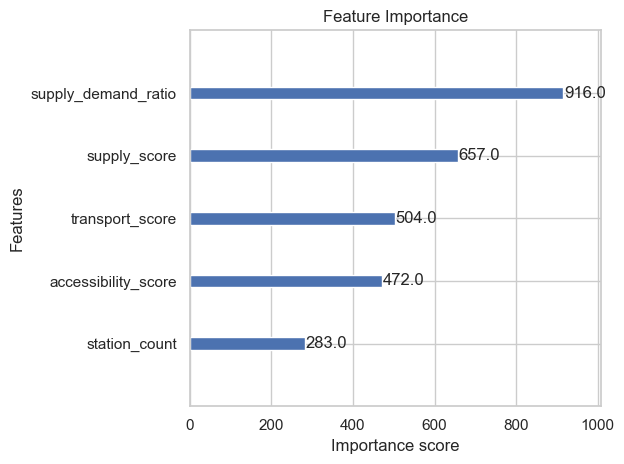

In [233]:
# 선택 사항

# 1. XGBoost 입력 feature 타입
print("XGBoost 입력 feature 타입:")
print(features_with_pred.dtypes)
print("")

from visualization.xgboost_visualizer import plot_feature_importance

# 2. 시각화
plot_feature_importance(model, max_num_features=10, save_path=f"{OUTPUT_IMG}/xgboost_importance.png")

# 3. metrics 저장
pd.DataFrame([metrics]).to_csv(f"{OUTPUT_DIR}/xgboost_metrics.csv", index=False)

# MCLP

In [255]:
from modeling.mclp_model import solve_mclp, run_sensitivity_analysis, print_elbow_summary, find_elbow_point

USE_MOCK_ELBOW = False  # True : mock 데이터 사용, False : 민감도 분석 실행

if USE_MOCK_ELBOW:
    # mock 데이터 정의
    elbow_candidates = pd.DataFrame([{
        'coverage_radius_km': 0.55,  # ≒ 0.005 degree
        'facility_limit': 70,
        'covered_demand': 462473.550,
        'coverage_rate': 64.58,
        'demand_satisfaction_ratio': 6606.76
    }])
    print("mock elbow_candidates 사용 중 (디버깅/테스트 목적)")
    
else:
    # 1. 민감도 분석 실행
    sensitivity_df = run_sensitivity_analysis(
        df=features,
        coverage_radii_km=[COVERAGE_RADIUS * 111],
        facility_limits=list(range(20, 101, 10)),
        demand_column='predicted_demand_score',
        verbose=True
    )

    # 2. delta 기반 elbow 지점 탐색
    elbow_candidates = find_elbow_point(sensitivity_df, threshold_ratio=0.6)

# 3. MCLP 실행
if not elbow_candidates.empty:
    best_row = sensitivity_df.loc[sensitivity_df['covered_demand'].idxmax()]
    elbow_row = elbow_candidates.iloc[0]

    # 출력
    print_elbow_summary(best_row, elbow_row)

    final_df, final_summary, _ = solve_mclp(
        df=features,
        coverage_radius=0.55 / 111.0,  # 반경 km → degree 환산
        facility_limit=int(elbow_row['facility_limit']),
        demand_column='predicted_demand_score',
        verbose=True
    )

    final_df.to_csv(f"{OUTPUT_DIR}/mclp_grid_features.csv", index=False)
    print("결과 저장 완료")
else:
    print("꺾이는 지점이 없어 저장을 건너뜁니다.")


반경 0.555km, 설치 20개 시나리오 실행 중...


커버리지 행렬 생성: 100%|██████████| 526/526 [00:21<00:00, 24.27it/s]


커버 수요: 205,707.64, 커버율: 28.73%

반경 0.555km, 설치 30개 시나리오 실행 중...


커버리지 행렬 생성: 100%|██████████| 526/526 [00:21<00:00, 24.30it/s]


커버 수요: 274,334.71, 커버율: 38.31%

반경 0.555km, 설치 40개 시나리오 실행 중...


커버리지 행렬 생성: 100%|██████████| 526/526 [00:21<00:00, 24.28it/s]


커버 수요: 331,398.83, 커버율: 46.28%

반경 0.555km, 설치 50개 시나리오 실행 중...


커버리지 행렬 생성: 100%|██████████| 526/526 [00:21<00:00, 24.67it/s]


커버 수요: 380,194.92, 커버율: 53.09%

반경 0.555km, 설치 60개 시나리오 실행 중...


커버리지 행렬 생성: 100%|██████████| 526/526 [00:21<00:00, 24.74it/s]


커버 수요: 423,914.29, 커버율: 59.20%

반경 0.555km, 설치 70개 시나리오 실행 중...


커버리지 행렬 생성: 100%|██████████| 526/526 [00:21<00:00, 24.71it/s]


커버 수요: 462,473.55, 커버율: 64.58%

반경 0.555km, 설치 80개 시나리오 실행 중...


커버리지 행렬 생성: 100%|██████████| 526/526 [00:21<00:00, 24.63it/s]


커버 수요: 497,837.65, 커버율: 69.52%

반경 0.555km, 설치 90개 시나리오 실행 중...


커버리지 행렬 생성: 100%|██████████| 526/526 [00:21<00:00, 24.58it/s]


커버 수요: 530,302.57, 커버율: 74.06%

반경 0.555km, 설치 100개 시나리오 실행 중...


커버리지 행렬 생성: 100%|██████████| 526/526 [00:21<00:00, 24.42it/s]


커버 수요: 558,514.35, 커버율: 78.00%

민감도 분석 결과 요약
 - 최적 설치 수 기준 (best_limit): 100개
   → 커버 수요: 558514.35, 커버율: 78.00%
 - 꺾이는 지점 기준 (elbow_point): 70개
   → 커버 수요: 462473.55, 커버율: 64.58%


커버리지 행렬 생성: 100%|██████████| 526/526 [00:21<00:00, 24.57it/s]


설치지 수: 70개
커버 수요: 462,473.55 / 총 수요: 716,087.70
커버율: 64.58%
결과 저장 완료


In [256]:
# 선택사항 - mclp 후 지역 시각화

from visualization.map_visualizer import visualize_selected_sites_map

visualize_selected_sites_map(
    features_path=f"{OUTPUT_DIR}/mclp_grid_features.csv",
    output_path=f"../outputs/maps/mclp_result_map.html"
)

설치지 시각화 저장 완료: ../outputs/maps/mclp_result_map.html


# 평가

In [257]:
features = pd.read_csv(f"{OUTPUT_DIR}/mclp_grid_features.csv")

# ✅ 기존 충전소 데이터 변경
stations = pd.read_csv(f"{DATA_DIR}/charging_stations_seoul_gridded.csv")

# 📊 평가 실행
baseline1 = evaluate_existing_stations(
    features=features,
    station_df=stations,
    lat_col='위도',
    lon_col='경도'
)
baseline2 = evaluate_random_installation(features, n=FACILITY_LIMIT)
baseline3 = evaluate_cluster_centers(features)
actual_facility_count = features['selected'].sum()

baseline4 = evaluate_mclp_result(
    df=features,
    facility_limit=actual_facility_count  # 🔁 여기를 실제 설치 수로!
)

[Baseline ① 기존 충전소 기준]
- 설치 격자 수: 523
- 커버 수요: 712,847.65
- 전체 수요: 716,087.70
- 커버율: 99.55%
[Baseline ② 랜덤 설치]
- 설치 격자 수: 30
- 커버 수요: 38,727.62
- 전체 수요: 716,087.70
- 커버율: 5.41%
[Baseline ③ 클러스터 중심 설치]
- 설치 격자 수: 1
- 커버 수요: 797.63
- 전체 수요: 716,087.70
- 커버율: 0.11%
[📊 MCLP 성능 평가]
- 설치 개수: 70
- 총 수요: 716,087.70
- 커버 수요: 110,704.64
- Coverage Rate: 15.46%
- Demand Satisfaction Ratio (DSR): 1,581.49
- 설치 효율성 (grid 단위): 1,581.49


In [157]:
from evaluation.baseline_evaluator import (
    evaluate_existing_stations,
    evaluate_random_installation,
    evaluate_cluster_centers,
    evaluate_mclp_result
)

# 🔁 기준 데이터
features = pd.read_csv(f"{OUTPUT_DIR}/mclp_selected_optimal.csv")
stations = pd.read_csv(f"{DATA_DIR}/charging_stations_seoul_gridded.csv")
optimal_facility_count = int(features['selected'].sum())  # 현재 60개

# 📊 평가 실행
baseline1 = evaluate_existing_stations(
    features=features,
    station_df=stations,
    lat_col='위도',
    lon_col='경도'
)

baseline2 = evaluate_random_installation(features, n=optimal_facility_count)

# baseline3 = evaluate_cluster_centers(features, n=optimal_facility_count)

baseline4 = evaluate_mclp_result(df=features, facility_limit=optimal_facility_count)

[Baseline ① 기존 충전소 기준]
- 설치 격자 수: 523
- 커버 수요: 712,847.65
- 전체 수요: 716,087.70
- 커버율: 99.55%
[Baseline ② 랜덤 설치]
- 설치 격자 수: 60
- 커버 수요: 78,115.31
- 전체 수요: 716,087.70
- 커버율: 10.91%
[📊 MCLP 성능 평가]
- 설치 개수: 60
- 총 수요: 716,087.70
- 커버 수요: 101,921.86
- Coverage Rate: 14.23%
- Demand Satisfaction Ratio (DSR): 1,698.70
- 설치 효율성 (grid 단위): 1,698.70


In [158]:
results = pd.DataFrame([
    {'baseline': '① 기존 충전소', **baseline1},
    {'baseline': '② 랜덤 설치', **baseline2},
    {'baseline': '③ 클러스터 중심', **baseline3},
    {'baseline': '④ MCLP 최적화', **baseline4}
])

from IPython.display import display
display(results)

,baseline,coverage,coverage_rate,covered_grids,dsr,efficiency,selected,total_demand
0,① 기존 충전소,712847.646545,99.547534,523.0,NaN,NaN,NaN,NaN
1,② 랜덤 설치,78115.313782,10.908624,60.0,NaN,NaN,NaN,NaN
2,③ 클러스터 중심,797.631165,0.111387,1.0,NaN,NaN,NaN,NaN
3,④ MCLP 최적화,101921.863525,14.233154,NaN,1698.697725,1698.697725,60.0,716087.700928


/var/folders/g0/wf5k560d45g5_rq_z1jbdpq40000gn/T/ipykernel_1131/1391480480.py:21: UserWarning: Glyph 9889 (\N{HIGH VOLTAGE SIGN}) missing from font(s) AppleGothic.
  plt.tight_layout()
/opt/anaconda3/envs/25bigdata/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9889 (\N{HIGH VOLTAGE SIGN}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


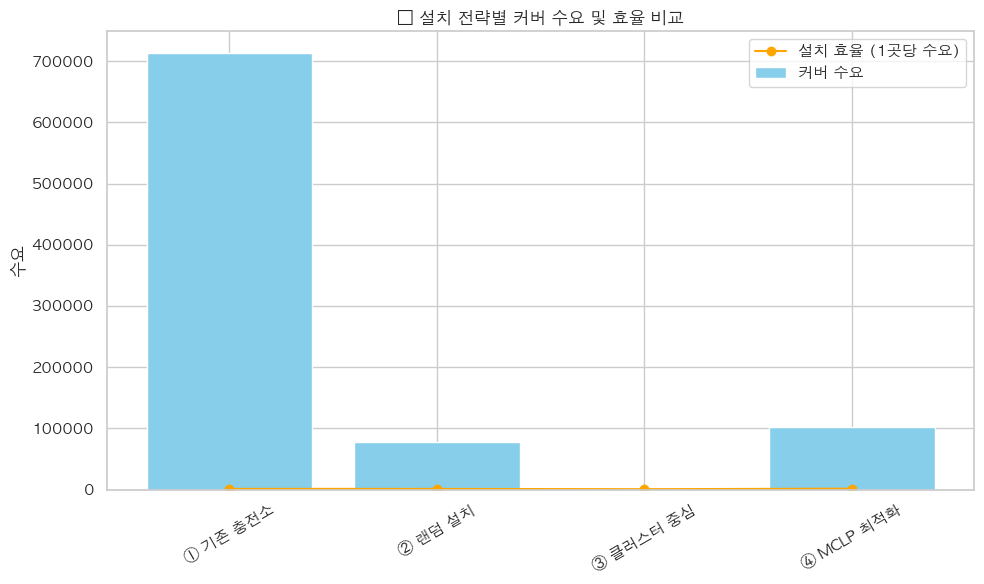

In [159]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl

# ✅ 한글 폰트 설정 (OS에 맞게 선택)
mpl.rcParams['font.family'] = 'AppleGothic'  # macOS
# mpl.rcParams['font.family'] = 'Malgun Gothic'  # Windows
mpl.rcParams['axes.unicode_minus'] = False

df = results.copy()
df['selected'] = df['selected'].fillna(df['covered_grids'])

plt.figure(figsize=(10, 6))
plt.bar(df['baseline'], df['coverage'], color='skyblue', label='커버 수요')
plt.plot(df['baseline'], df['coverage'] / df['selected'], color='orange', marker='o', label='설치 효율 (1곳당 수요)')

plt.xticks(rotation=30)
plt.ylabel("수요")
plt.title("⚡ 설치 전략별 커버 수요 및 효율 비교")
plt.legend()
plt.tight_layout()
plt.show()

In [94]:
import folium
from geopy.distance import geodesic
import matplotlib.cm as cm
import matplotlib.colors as mcolors

def plot_all_coverage_strategies(features, strategy_dict, radius_km=2.0):
    """
    여러 설치 전략을 한 지도에 격자 커버리지를 색상별로 구분하여 시각화

    Parameters:
    - features: 전체 grid DataFrame (center_lat, center_lon 포함)
    - strategy_dict: {label: 설치지 DataFrame} 형식
    - radius_km: 커버 반경
    """
    # 지도 초기화 (서울 중심)
    m = folium.Map(location=[37.55, 126.98], zoom_start=11, tiles='cartodbpositron')

    # 고유 색상 설정
    color_map = {
        '① 기존 충전소': 'red',
        '② 랜덤 설치': 'green',
        '③ 클러스터 중심': 'purple',
        '④ MCLP 최적화': 'blue'
    }

    for label, install_df in strategy_dict.items():
        color = color_map[label]

        for _, grid in features.iterrows():
            grid_center = (grid['center_lat'], grid['center_lon'])
            for _, site in install_df.iterrows():
                site_center = (site['center_lat'], site['center_lon'])
                if geodesic(grid_center, site_center).km <= radius_km:
                    folium.CircleMarker(
                        location=grid_center,
                        radius=2.5,
                        color=color,
                        fill=True,
                        fill_opacity=0.3,
                        popup=f"{label} 커버"
                    ).add_to(m)
                    break

        # 설치 위치 강조
        for _, site in install_df.iterrows():
            folium.Marker(
                location=(site['center_lat'], site['center_lon']),
                icon=folium.Icon(color=color, icon='bolt', prefix='fa'),
                popup=f"{label} 설치지"
            ).add_to(m)

    return m

In [ ]:
# 기존 충전소
existing_stations_df = pd.read_csv(f"{DATA_DIR}/charging_stations_seoul_gridded.csv")
existing_stations_df = existing_stations_df.dropna(subset=['위도', '경도']).copy()
existing_stations_df = existing_stations_df.rename(columns={'위도': 'center_lat', '경도': 'center_lon'})

# MCLP 설치지
mclp_selected_df = features[features['selected'] == 1][['grid_id', 'center_lat', 'center_lon']].copy()

# 랜덤 설치
np.random.seed(42)
random_sites_df = features.sample(n=FACILITY_LIMIT)[['grid_id', 'center_lat', 'center_lon']].copy()

# 클러스터 중심 (각 클러스터마다 중심 1개씩)
cluster_center_df = features.groupby('cluster')[['center_lat', 'center_lon']].mean().reset_index()

# 전략별 dict
strategy_dict = {
    "① 기존 충전소": existing_stations_df,
    "② 랜덤 설치": random_sites_df,
    "③ 클러스터 중심": cluster_center_df,
    "④ MCLP 최적화": mclp_selected_df
}

# 지도 생성 및 저장
map_all = plot_all_coverage_strategies(features, strategy_dict, radius_km=2.0)
map_all.save("../outputs/maps/coverage_comparison_map.html")
map_all